In [155]:
#shell of notebook

#Company Report Imports
import pandas as pd

import plotly.graph_objects as go

import networkx as nx
import ast
%matplotlib inline  
#from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

#Company Suggestions Imports
import re
import sys
from IPython.display import display, HTML

#Display Dropdown Imports
import ipywidgets as widgets
from IPython.display import display
import functools

#Display Button Imports:
import asyncio



# 0. Core/Background Functions

### Display Dropdown

In [156]:
#create the sec codes dataset
#sic_codes = pd.read_csv('corpwatch_api_tables_csv/sic_codes.csv', sep = "\t", escapechar='\\')
#sic_sectors = pd.read_csv('corpwatch_api_tables_csv/sic_sectors.csv', sep = "\t", escapechar='\\')

In [157]:
# sic_sectors_codes = pd.merge(sic_codes,
#                      sic_sectors,
#                      on='sic_sector', 
#                      how='left')x
sic_sectors_codes = pd.read_csv("sector_output.csv")

In [158]:
def on_button_clicked(b, rs_="some_default_string"):
    #test_print = dd.value
    print(rs_)

def valfunc(val):
    print(val)

def display_drop_down(df_column):
    """
    Passes in a Dataframe column to set the dropdown bar. Use in tandem with button code
    to create clickable button to direct users to different functions
    """
    dd = widgets.Dropdown(options= 
          df_column.unique(),
    value=df_column.iloc[0],
    description='Type:',
    disabled=False,
    )
    
    #Code required to display button first time 
    widgets.Button.on_click.__doc__
    
    #Code required to display button 
    button = widgets.Button(description="Go")
    output = widgets.Output()
    
    #displays dropdown and button
    display(dd, button, output) 
    
    button.on_click(functools.partial(on_button_clicked,rs_=dd.value ))
    print('2')
    return dd

#dd = display_drop_down(sic_sectors_codes['sector_group_name']) 

def test():
    print('1')
    df = display_drop_down(sic_sectors_codes['sector_group_name']) 
    print('3')

test()

1


Dropdown(description='Type:', options=(' Agriculture, forestry, and fishing', 'Mining', 'Construction', 'Manuf…

Button(description='Go', style=ButtonStyle())

Output()

2
3


In [159]:
def display_drop_down(df_column):
    """
    Passes in a Dataframe column to set the dropdown bar. Use in tandem with button code
    to create clickable button to direct users to different functions
    """
    dd = widgets.Dropdown(options= 
          df_column.unique(),
    value=df_column.iloc[0],
    description='Type:',
    disabled=False,
    )

    return dd

dd = display_drop_down(sic_sectors_codes['sector_group_name']) #set this to the column you like to define the code 


In [160]:
def unique_non_nan(elem):
    """
    To be used in aggregation functions, rolls elements into a list, discaring nans
    """
    return [a for a in list(pd.unique(elem)) if pd.notna(a)]

def deduplicate(col, ls):
    if col in ls: ls.remove(col)
    return ls

In [320]:
#Column Names 
PARENT_CW_ID = "parent_cw_id"
CHILD_COMPANY_NAMES = "child_company_names"
CHILD_CW_IDS = "child_cw_ids"
PARENT_CW_IDS = "parent_cw_ids"
PARENT_COMPANY_NAMES = "parent_company_names"
CW_ID = 'cw_id'
INDUSTRY_NAME = 'industry_name'
SECTOR_NAME = 'sector_name'
SECOTR_GROUP_NAME = 'sector_group_name'
NUM_PARENTS = 'num_parents'
NUM_CHILDREN = 'num_children'
TOP_PARENT_ID = 'top_parent_id'
COMPANY_NAME = 'company_name'
CHILD_CW_ID_LIST = 'child_cw_id_list'
PARENT_CW_ID_LIST = 'parent_cw_id_list'


In [321]:
def create_master_company_data(output_name, corp_watch_dir = "corpwatch"):
    company_info = pd.read_csv('corpwatch_api_tables_csv/company_info.csv', sep = "\t", escapechar='\\',  low_memory=False)
    recent_companies = company_info[company_info['most_recent'] == 1]
    
    #read relationships file which we will use to show parent and child relationships 
    relationships = pd.read_csv('corpwatch_api_tables_csv/relationships.csv', sep = "\t", escapechar='\\')
    relationships_recent = relationships[relationships['year'] > 2018]
    
    #group by the parent cw id, to get a list of children 
    parent_child_groups = relationships_recent.groupby(['parent_cw_id']).agg({
     'parent_cw_id': "first",
     'cw_id': unique_non_nan,
     'clean_company': unique_non_nan})
    
    parent_child_groups['child_cw_id_list'] = parent_child_groups.apply(lambda row: deduplicate(row['parent_cw_id'], row.cw_id), axis = 1)
    #parent_child_groups.rename(index = {'parent_cw_id': "cw_id"}, inplace = False)
    parent_child_groups = parent_child_groups.rename(
    columns= {
    "cw_id": CHILD_CW_IDS,
    'clean_company': CHILD_COMPANY_NAMES})

    parent_child_groups = parent_child_groups[['child_cw_id_list']]
    
    #group by the cw_id to get a list of parents for each cw id 
    child_parent_groups = relationships_recent.groupby(['cw_id']).agg({
     'parent_cw_id' : lambda x:  unique_non_nan(x),
     'clean_company': lambda x: unique_non_nan(x)})
    child_parent_groups['child_cw_id'] = child_parent_groups.index
    child_parent_groups['parent_cw_id_list'] = child_parent_groups.apply(lambda row: deduplicate(row['child_cw_id'], row['parent_cw_id']), axis =1)
   
    company_joined1 = pd.merge(recent_companies,
                     parent_child_groups, 
                     left_on= 'cw_id',
                     right_on='parent_cw_id',          
                     how='left')
    
    company_joined2 =  pd.merge(company_joined1,
                     child_parent_groups, 
                     left_on= 'cw_id',
                     right_on='child_cw_id',
                     how='left')
    company_joined2.to_csv(output_name)

In [322]:
#Run the code to create the company master table 
COMPANY_MASTER_TABLE_NAME = "company_master_table.csv"
#Only need to run this code once 
#create_master_company_data(COMPANY_MASTER_TABLE_NAME)

## List Parse

In [323]:
#required to read the list column from a file 
def list_parse(s):
    strings = str(s).strip("[]").split(",")
    ls = []
    for i in strings:
        try:
            ls.append(int(float(i.strip())))
        except (ValueError):
            ""
    return ls

## Code to read in the company file

In [557]:
#read in company master file, parse, add location information 

def read_company_file():
    data = pd.read_csv("company_master_table.csv", 
                   dtype={"child_cw_id_list" :'str',
                          "parent_cw_id_list": 'str'}, converters={1:ast.literal_eval})
    return data

def clean_company_data(data):
    data[CHILD_CW_ID_LIST] = data[CHILD_CW_ID_LIST].apply(lambda x: list_parse(x))
    data[PARENT_CW_ID_LIST] = data[PARENT_CW_ID_LIST].apply(lambda x: list_parse(x))
    families = data[((data[NUM_PARENTS]> 0) | (data[NUM_CHILDREN] > 0))]  #i might not want to do this
    
    data[INDUSTRY_NAME] = data[INDUSTRY_NAME].apply(lambda x: x.strip())
    data[SECOTR_GROUP_NAME] = data[SECOTR_GROUP_NAME].apply(lambda x: x.strip())
    data[SECTOR_NAME] = data[SECTOR_NAME].apply(lamda x: x.strip())
    #join with the location 
    location = pd.read_csv('corpwatch_api_tables_csv/company_locations.csv', sep = "\t", escapechar='\\')
    location_filtered = location[location['max_year'] > 1950] #changed by max in the hope we'll get more information
    location_aggregations = {'city': "first",
                         'state': "first",
                         'country_code':  "first"
                         }
    location_agg = location_filtered.groupby('cw_id').agg(location_aggregations)
    
    families_location_Domestic = pd.merge(families, location_agg,
                     left_on='cw_id', 
                     right_on='cw_id',
                     how='left')
    
    #added countries
    countries = pd.read_csv('corpwatch_api_tables_csv/un_countries.csv', sep = "\t", escapechar='\\')
    countries_agg = pd.DataFrame(countries, columns = ['country_code', 'country_name'])

#     countries_aggregations = {'country_code':  "first",
#                               'country_name':  "first"}
    
    #country_agg = countries.groupby('country_code').agg(countries_aggregations)
    
    families_location_International = pd.merge(families_location_Domestic, countries_agg,
                     left_on='country_code', 
                     right_on='country_code',
                     how='left')
    
    #create the sec codes dataset
    #sic_codes = pd.read_csv('corpwatch_api_tables_csv/sic_codes.csv', sep = "\t", escapechar='\\')
#     sic_sectors_codes = pd.merge(sic_codes,
#                      sic_sectors,
#                      on='sic_sector', 
#                      how='left')    
    sic_sectors = pd.read_csv('corpwatch_api_tables_csv/sic_sectors.csv', sep = "\t", escapechar='\\')
    print(sic_sectors.head())

    
    ## get a dataframe containing all granularities of sectors
    families_location = pd.merge(families_location_International,
                     sic_sectors[['sic_sector','sector_group', 'sector_group_name']],
                     on='sic_sector', 
                     how='left')
    families_location.head()
    
    
    #index on cw_id for faster lookup 
    indexed = families_location.set_index(CW_ID) ## should not use the filtered list
    family_groups = families_location.groupby(families_location[TOP_PARENT_ID])
    return indexed, family_groups

SyntaxError: invalid syntax (<ipython-input-557-f14702a9877c>, line 16)

In [558]:
company_master_data = read_company_file()

company_data, family_groups = clean_company_data(company_master_data)

#Used to create sector tables, not needed if you have the file
#company_data = company_data.reset_index()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning:

Columns (9,11,22,23) have mixed types. Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning:

Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.



   sic_sector                         sector_name  sector_group  \
0         100      Agricultural production- crops             1   
1         200  Agricultural production- livestock             1   
2         700               Agricultural services             1   
3         800                            Forestry             1   
4         900      Fishing, hunting, and trapping             1   

                     sector_group_name  
0   Agriculture, forestry, and fishing  
1   Agriculture, forestry, and fishing  
2   Agriculture, forestry, and fishing  
3   Agriculture, forestry, and fishing  
4   Agriculture, forestry, and fishing  


In [559]:
company_master_data.head()

,Unnamed: 0,row_id,cw_id,most_recent,year,cik,irs_number,best_location_id,sic_code,industry_name,...,top_parent_id,company_name,max_year,min_year,no_sic,child_cw_id_list,parent_cw_id,clean_company,child_cw_id,parent_cw_id_list
0,0,18,37,1,2019,3153,630004250.0,74,4911.0,Electric services,...,37,ALABAMA POWER CO,2019,2003,0,"[1665, 993179, 101861, 1018259, 781, 101870, 1...","[12009.0, 22569.0, 781.0, 1197.0, 1665.0]",['Alabama Power Co'],37.0,"[12009, 22569, 781, 1197, 1665]"
1,1,24,45,1,2019,3499,510100517.0,88,6798.0,Real estate investment trusts,...,9019,ALEXANDERS INC,2019,2003,0,"[1038175, 1038176, 1038177, 1038178, 1038179, ...","[14480.0, 9019.0]",['Alexanders Inc'],45.0,"[14480, 9019]"
2,2,39,69,1,2019,4515,131502798.0,137,4512.0,"Air transportation, scheduled",...,105,AMERICAN AIRLINES INC,2019,2003,0,"[964843, 964842, 411832, 411833, 416126, 41613...",[105.0],['American Airlines Inc'],69.0,[105]
3,3,65,120,1,2019,6879,540124790.0,246,4911.0,Electric services,...,75,APPALACHIAN POWER CO,2019,2003,0,"[993634, 834826, 696650, 992937, 136825, 95658...","[956587.0, 1029138.0, 75.0, 927.0, 1345.0, 149...",['Appalachian Power Co'],120.0,"[956587, 1029138, 75, 927, 1345, 1492, 1674]"
4,4,79,130,1,2019,7323,831918668.0,273,4911.0,Electric services,...,1180,ENTERGY ARKANSAS LLC,2019,2003,0,"[899487, 1001712, 1180]",[590084.0],['Entergy Arkansas LLC'],130.0,[590084]


In [560]:
#Sector codes 
PARENT_SECTOR_RANK = 'parent_sector_rank'
PARENT_INDUSTRY_RANK = 'parent_industry_rank'
PARENT_SECTOR_GROUP_RANK = 'parent_sector_group_rank'
def create_sector_rankings(family_groups):  
    famlies_by_size = family_groups.agg({'cw_id': 'count'})
    famlies_by_size['subsidiary_count'] = famlies_by_size['cw_id']
    famlies_by_size.head()
    sector_merge = pd.merge(famlies_by_size['subsidiary_count'], company_data[[SECTOR_NAME, INDUSTRY_NAME, 'sector_group_name']], left_index=True, right_index=True, how='inner')
    sector_merge['parent_id'] = sector_merge.index
    sector_merge[PARENT_SECTOR_RANK] = sector_merge.groupby(SECTOR_NAME)["subsidiary_count"].rank("first", ascending=False)
    sector_merge[PARENT_INDUSTRY_RANK] = sector_merge.groupby(INDUSTRY_NAME)["subsidiary_count"].rank("first", ascending=False)
    sector_merge[PARENT_SECTOR_GROUP_RANK] = sector_merge.groupby('sector_group_name')["subsidiary_count"].rank("first", ascending=False)
    return sector_merge

parent_rankings = create_sector_rankings(family_groups)
parent_rankings = pd.merge(parent_rankings, company_data[[COMPANY_NAME]], left_on = 'parent_id', right_index=True, how = 'inner')

In [561]:
parent_rankings.head()

,subsidiary_count,sector_name,industry_name,sector_group_name,parent_id,parent_sector_rank,parent_industry_rank,parent_sector_group_rank,company_name
2,31,Transportation equipment,Aircraft & parts,Manufacturing,2,49.0,3.0,554.0,AAR CORP
3,1277,Chemicals and allied products,Pharmaceutical preparations,Manufacturing,3,3.0,2.0,7.0,ABBOTT LABORATORIES
13,6,Fabricated metal products,"Cutlery, handtools & general hardware",Manufacturing,13,40.0,9.0,995.0,ACME UNITED CORP
16,22,Wholesale trade--nondurable goods,Wholesale-petroleum & petroleum products (no b...,"Transportation, communications, and utilities",16,25.0,5.0,900.0,ADAMS RESOURCES & ENERGY INC
17,4,Electrical and electronic equipment,Radio & tv broadcasting & communications equip...,Manufacturing,17,174.0,22.0,1119.0,BK Technologies Inc


In [562]:
industry_totals = parent_rankings.groupby(INDUSTRY_NAME)['parent_id'].count()
sector_totals = parent_rankings.groupby(SECTOR_NAME)['parent_id'].count()
sector_group_totals = parent_rankings.groupby(SECTOR_GROUP_NAME ).count()

NameError: name 'SECTOR_GROUP_NAME' is not defined

In [ ]:
sector_totals.loc['Agricultural services']

In [319]:
def print_parent_rankings(df, parent_id):
    row = df.loc[parent_id]
    print("Rankings by number of subsidiaries for parent:")
    sector_group = row['sector_group_name']
    sector = row[SECTOR_NAME]
    industry = row[INDUSTRY_NAME]
    print(" * " + str(int(row[PARENT_SECTOR_GROUP_RANK])) + " largest of " + str(sector_group_totals.loc[sector_group]['parent_id']) + " in " + str(sector_group) + " group")
    print(" * " + str(int(row[PARENT_SECTOR_RANK])) + " largest of " + str(sector_totals.loc[sector]) +  " in " + str(row[SECTOR_NAME]) + " sector")
    print(" * " + str(int(row[PARENT_INDUSTRY_RANK])) + " largest of " + str(industry_totals.loc[industry]) +  " in " + str(row[INDUSTRY_NAME]) + " industry")

print_parent_rankings(parent_rankings, 17)

Rankings by number of subsidiaries for parent:
 * 1119 largest of 1380 in Manufacturing group
 * 174 largest of 188 in Electrical and electronic equipment sector
 * 22 largest of 23 in Radio & tv broadcasting & communications equipment industry


industry_name
Abrasive, asbestos & misc nonmetallic mineral prods    4
Accident & health insurance                            8
Adhesives & sealants                                   4
Agricultural chemicals                                 8
Agricultural prod-livestock & animal specialties       1
Name: parent_id, dtype: int64

In [353]:
def get_subsidiary_ranking(data, group_type, col_name):
    subsidiaries_by_industry = data.groupby([group_type, TOP_PARENT_ID]).agg({'row_id': 'count'})

    sorted_subsidiaries = subsidiaries_by_industry.sort_values([group_type, 'row_id'], ascending = True)
    sorted_subsidiaries[col_name] = sorted_subsidiaries.groupby([group_type])['row_id'].rank('first', ascending=False)
    sorted_subsidiaries.rename(columns = {"row_id": 'subsidiary_number'}, inplace = True)
    with_name = pd.merge(sorted_subsidiaries, company_data[[COMPANY_NAME]], left_on = TOP_PARENT_ID, right_index=True, how = 'inner')
    
    return with_name

In [361]:
SUB_INDUSTRY_RANKING = 'sub_industry_ranking'
subsidiaries_by_industry = get_subsidiary_ranking(company_data, INDUSTRY_NAME, SUB_INDUSTRY_RANKING)
SUB_SECTOR_RANKING = 'sub_sector_ranking'
subsidiaries_by_sector = get_subsidiary_ranking(company_data, SECTOR_NAME , SUB_SECTOR_RANKING)
SUB_SECTOR_GROUP_RANKING = 'sub_sector_group_ranking'
subsidiaries_by_sector_group = get_subsidiary_ranking(company_data, SECOTR_GROUP_NAME, SUB_SECTOR_GROUP_RANKING)

In [362]:
def print_subsidiaries_by_industry(df, company_id, topIndustries):
    for i in topIndustries:
        row = df.loc[(i, company_id)]
        print(i +  ":    " + str(row[SUB_INDUSTRY_RANKING]))         
  

### Button Code

In [21]:
slider = IntSlider()

async def f():
    for i in range(10):
        print('did work %s'%i)
        x = await wait_for_change(slider, 'value')
        print('async function continued with value %s'%x)
asyncio.ensure_future(f())

slider

NameError: name 'IntSlider' is not defined

## Helper Functions for Company Report Function

In [22]:
#helper function to extract the location from a row as (Country, City)
def create_location_string(row):
    country = row['country_name']
    city = row['city']
    if country == 'nan':
        return ""
    elif str(country) == 'UNITED STATES':
        state = row['state']
        return str(city) + ", " + str(state)
    else:
        return str(city) + ", " + str(country)

In [23]:
import math

def print_grouped_columns(df, column_name, sortby, limit = 100):      
    for (g, data) in df:
        print(g)
        d = data.sort_values(by = sortby)                        
        for (i,c) in d.iterrows():
            print("\t \t \t " + str(c[column_name]) + " " +  create_location_string(c) +" ") 


In [24]:
def get_name_by_id(index_df, cw_id):
    row = index_df.loc[cw_id]
    return row[COMPANY_NAME]

# A. Start Page

This program contains a database of US-based multinational companies, as well as their subsidiaries. This information was sourced by CorpWatch, a San Francisco-based corporation accountability company, using data found in the Security and Exchange Commission (SEC) EDGAR database. 

You can use this program to search for a specific company, or you can search for the most prominent companies in a particular industry or region.

Disclaimer: Because the SEC database is a required only for US Companies, this dataset only contains US-Based multinational companies and their domestic and international subsidiaries. International 

### Workflow
1. Users choose what kind of search they want


### Choices

- Choose a Company (Go to -> __C. Company Query__)

- Choose a Sector (Go to -> __B. Search by Sector__)

- (Optional) Choose from top multinational companies


##### Disclaimer
Only includes US companies

In [25]:
def AStart():
    '''Display start page + options'''
    #B = Sector
    #C = Company
    while True:
        choice = input("Please select an option: ")
        if choice == "B":
            BSector()
        elif choice == "C":
            CCompany()
        else:
            print("sorry I didn't get that, please try again")

## B. Search by Sector

### Workflow
1. Users select Sector Group (dropdown)
1b. Users select Sector (dropdown)
1c. Users select Industry (dropdown)

2. Top Players Results displayed
3. Users select company to view report (dropdown) (Go to -> __D. Company Report Page__)
3b. Users go back (Go to -> __A. Start Page__)

### Features
- Dropdown Widgets: Sector selection
- Top Players Results
    - Groupby: Industries
    - Groupby: Top Parent IDs
- Dropdown Widgets: Company selection



In [563]:
def BSector():
    '''display sectors options'''
#     display_drop_down(Sector_Groups)
#     display_drop_down(Sectors)
#     display_drop_down(Industries)
    #SIC_choice = "Sector/industry"
    
    #search_by_sector(SIC_choice)
    #displays top 25 results
    
    #company_choice = display_drop_down(Companies)
    #display_company_report = company_choice
    
    #We should change these its hard to read 
    #print("industries\n", sic_sectors_codes['industry_name'].unique() )
    #print("Sector group\n", sic_sectors_codes['sector_group_name'].unique() )
    #print("Sector name\n", sic_sectors_codes['sector_name'].unique() )
    
    sector_var = input("Select:\nA - For getting top comapnies by industries\nB - For getting top comapnies by sector group\nC - For getting top comapnies by sector\n")
    #sector_name = input("Enter the name of the sector or industry")
    sector_name = None
    sec_df = None
    if sector_var == "A":
        print("Sector name\n", sic_sectors_codes['sector_name'].unique() )
        sector_name = input("Enter the name of the sector")
        sec_df = subsidiaries_by_sector[subsidiaries_by_sector.index.get_level_values(0) == sector_name].sort_values(SUB_SECTOR_RANKING, ascending=True)

    elif sector_var == "B":
        print("Sector group\n", sic_sectors_codes['sector_group_name'].unique() )
        sector_name = input("Enter the name of the sector group")
        print(sector_name)
        sec_df = subsidiaries_by_sector_group[subsidiaries_by_sector_group.index.get_level_values(0) == sector_name].sort_values(SUB_SECTOR_GROUP_RANKING, ascending = True)
      
    elif sector_var == "C":
        print("industries\n", sic_sectors_codes['industry_name'].unique() )
        sector_name = input("Enter the name of the industry")
        print(sector_name)
        sec_df = subsidiaries_by_industry[subsidiaries_by_industry.index.get_level_values(0) == sector_name].sort_values(SUB_INDUSTRY_RANKING, ascending = True)       
    
    sec_df.index = sec_df.index.get_level_values(1)
    display(sec_df)
    d = sec_df[COMPANY_NAME].to_dict()
    cw_id = display_drop_down_beta(dict(map(reversed, d.items())))
    df = generate_company_report(cw_id)
    return_to_start()
    

In [541]:
# rachel will start
def display_drop_down_beta(options_list):
    """
    displays a drop down for the items in options list, collects choice from the user and returns a string with
    their choice
    
    Requirements: Sector_group_name, Sector_name, Industry_name
    """
    for k in options_list.keys():
        print (k)
    choice = input('Type the item you would like to choose')
    sel  = int(options_list[choice])
    #print(options_list[choice])
    return sel

In [542]:
#prakar
def getTop25Companies(sectortype, name):
    """
    returns list of a parent companies in that sub sector, ranked by subsidiaries
    """
    topPlayers = pd.read_csv(sectortype + ".csv")
    com_names = pd.merge(topPlayers[topPlayers[sectortype]==name].head(25),
                         company_data,
                         left_on='top_parent_id',
                         right_on = 'cw_id',
                         how='left'
                        )
    
    
    return com_names



## C. Search by Company

### Workflow
1. Users search by Company Name
1b. Users select Sector (dropdown)
1c. Users select Industry (dropdown)

2. Company Results displayed
3. Users select company to view report (dropdown) (Go to -> __D. Company Report Page__)
3b. Users go back (Go to -> __A. Start Page__)

### Features
- Dropdown Widgets: Sector selection
- Weighted Zone Search
    - Number of Children
    - Company Type
    - Sector Type
- Dropdown Widgets: Company selection

In [543]:
def CCompany():
    
    print('Please input a company you would like to search for')

    company = input('> ').upper()
    sector = input('What sector are you looking for: ')

    print("Searching for relevant companies with names matching " + company + " in sector " + sector)
    
#     MAX_REPEATS = 10
#     repeats = 0
#     company_id = None
#     choice = None

    df = display_company_suggestions(company_data, company, sector)
    
    
#     while(repeats < MAX_REPEATS):
#         print("enter the loop")
#         print("data frame size " + str(df.size))
#         repeats = repeats = repeats + 1
        
    #finds no search results    
    if df.size == 0:
        print("I'm sorry, I wasn't able to find a company with those attributes. Would you like to do next:")
        print("1) Search for another company?")
        CCompany()
        
    #If it finds only one result    
    elif len(df.index) == 1:
        cw_id = df['cw_id'].iloc[0]
        df = generate_company_report(cw_id)
        # This continued logic should be removed 
#         print('What would you like to do now:')
#         print('1) Search for another Company')
#         print('2) Go Back')
#         print('3) Get Company Report')
    elif len(df.index) > 1:
        results= pd.DataFrame(df, columns = ['company_name', 'num_children', 'sector_name', 'weighted_result', 'company_type'])
        display(results)
        print(" ======================================")
        print('Which company would you like to select:')
        d = df[COMPANY_NAME].to_dict()
        company_names = dict(map(reversed, d.items()))
        cw_id = display_drop_down_beta(company_names)
        
        df = generate_company_report(cw_id)
#         if cw_id is not None:
#             if choice == 1:
#                 df = display_company_suggestions(company_data, company, sector)
#             elif choice == 2:
#                 print('Please input a company you would like to search for')
#                 print('Tips for searching:')
#                 print('-You can enter a partial number')
#                 company = input('> ').upper()
#                 sector = input('What sector are you looking for: ')

#             elif choice == 3:
#                 display_breakdown(company_id)
#             else:
#                 print('Sorry I didnt get that, please select another choice')
    return_to_start()

In [544]:

# Rachel has re written this slightly 
import re
import sys
from IPython.display import display, HTML
def display_company_suggestions(df, company, sector=None):
    company_data['company_type'] = company_data['company_name'].apply(lambda x: get_comp_type(x))
    print("Displaying the sugessionts ")
    
    '''
    first test if name entered finds something in the database
    '''
    df['weighted_result'] = 'default'

    df = df[ df['company_name'].str.match(company) ]
    #print(df)
    #print(len(df.index))
    if df.size != 0:
        df['weighted_result'] = df[['num_children','sector_name','company_type']].apply(lambda x: weighted_result(x,sector), axis=1)
        df = df.sort_values(by=['weighted_result'], ascending = False)
    #display(df)
    return df


In [545]:
#### weighting for search results

def weighted_result(x, sector=None):
    #use zone scoring to compute weight of query result    
    child_weight = .5
    sector_weight = .3
    company_weight = .2
    
    #returns positive if there are any children (favors multinational companies)
    child = (0,1)[x['num_children'] > 0]
    #returns positive if the company is an INC or CORP datatype (More likely to be a US multinational)
    company = (0,1)[x['company_type'] == 'INC' or x['company_type'] == 'CORP' or x['company_type'] == None]
    
    #attempts to put sector(if given) into related companies (replace with dropdown if possible)
    try:
        #print(sector.lower())
        #print(sector.lower() in x['sector_name'].lower())
        sect = (0,1)[sector.lower() in x['sector_name'].lower()]
    except:
        sect = 0

    return child_weight * child + sector_weight * sect + company_weight * company


In [546]:
#print(None in company_data['sector_name'].iloc[0])

## D. Company Report Page

### Workflow

1. User is shown page
2. User select another company to view report (dropdown) (Go to -> __D. Company Report Page__)
2b. Users go back (Go to -> __A. Start Page__)


### Features

#### Parent Company
- Relationship Map
- Company Breakdown (% of Company Industries)
    - Groupby: Top Parent ID
    - Groupby: Sector
    - Top Players Ranking
        - Top Players Results
- Foreign/Domestic (% of Domestic vs. International Companies)
    - Groupby: Location
    - Groupby: State
- Dropdown Widgets: Company selection


#### Subsidiary
- Similar Companies
    - Groupby: Top Parent ID
    - Groupby: Sector
- Dropdown Widgets: Company selection

In [547]:
def create_top_parent_report(group_df, company_id, name_string):
    #rankings
    
    
    
    agg_dictionary = {"row_id" : "count",
                  CW_ID: unique_non_nan,
                  COMPANY_NAME: unique_non_nan,
                 }
    COMPANY_COUNT = "company_count"
    #aggregate by industry
    industry_df_group = group_df.groupby(by = "industry_name")
    industry_df = industry_df_group.agg(agg_dictionary)
    industry_df.rename(columns = {"row_id": COMPANY_COUNT}, inplace = True)
    
    #get the top industries in readable way
    #should be cleaned up
    top_industries_df = industry_df.sort_values(by = COMPANY_NAME, ascending=False)
    top_industries = [k for k in top_industries_df[COMPANY_COUNT].to_dict().keys()]
   
    #sectors 
    sectors = group_df.groupby(SECTOR_NAME).count() 
    sectors.rename(columns = {"row_id": COMPANY_COUNT}, inplace = True)
    subsidiaries = group_df[COMPANY_NAME]

    print("Parent company information "  + str(name_string)) 
    locations = group_df.groupby('country_name').agg(agg_dictionary)
    country_codes = [k for k in locations['row_id'].to_dict().keys()]
    if len(country_codes) > 1:
        print ("* Is Multinational") # we can do better ;p
    print("* Has " + str(len(subsidiaries)) + " subsidiaries")
    
    #change to take the top 3 or so industries if they exist 
    print("* Top industries " + str(top_industries))
    
    #It shows basically nothing if we take out Unknown Industry/Sector, so I'm leaving it in 
    industris_clean = industry_df[industry_df.index != "Unknown Industry"]
    # make pie plots 
    
    industris_clean.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries By Industry") 
    #industry_df.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries By Industry") 

    plt.show()
    
    sectors_clean = sectors[sectors.index != "Unknown Sector"]
    sectors_clean.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries by Sector")
    #sectors.plot.pie(y = COMPANY_COUNT, legend = False, title = "Subsidiaries by Sector")

    plt.show()
    
    print_parent_rankings(parent_rankings, company_id)
    
    
    print("Subsidiaries locations: " + str(set(country_codes)))
    print("==================== SUBSIDIARIES BY INDUSTRY ============================= ")
    print_grouped_columns(industry_df_group, COMPANY_NAME, NUM_CHILDREN, limit = 100)
    
    return industry_df_group
 

In [548]:
#Create a company report for any company 
#prints some information and the parent company report 
def generate_company_report(company_id):
    co_name = get_name_by_id(company_data, company_id)
    row = company_data.loc[company_id]
    industry = row[INDUSTRY_NAME]
    parents = row[PARENT_CW_ID_LIST]
    top_parent = row[TOP_PARENT_ID]
    top_parent_name = get_name_by_id(company_data, top_parent)
    print("Company: " + str(co_name) + "  company_id: " + str(company_id))
    print("Location: " + create_location_string(row))    
    print("=====================")
    print("")
    #size by industry, number of subsidiaries

    if top_parent != company_id:
        if top_parent in parents:
            print("* t is a subsidiary of: " + str(top_parent_name) + " (" + str(top_parent) + ")")
        else:
            print("* is owned by " + str(parents))
            print("* is an indirect subsidiary of  ")
            print("* is a subsidiary of: " + str(top_parent_name) + " " + str(top_parent) + ")")
        #Ask the user if they would like to see the top parent report before showing it? 
        
        if float(row[NUM_CHILDREN]) > 0.0:
            children = row[CHILD_CW_ID_LIST]
            print("* owns " + str(children) + " companies")
    group = family_groups.get_group(top_parent)   
    create_top_parent_report(group, top_parent, top_parent_name)
    
    #wish list 
    #is a multinational
    #ranking by industry
    #number of child locations
    #subsidiaries locations


# ACTUAL PAGE


In [549]:

# Rachel has re written this slightly 
import re
import sys
from IPython.display import display, HTML
def display_company_suggestions(df, company, sector):
    print("Displaying the suggestions")

    df['weighted_result'] = 'default'

    df = df[ df['company_name'].str.match(company) ]

    df['weighted_result'] = df[['num_children','sector_name','company_type']].apply(lambda x: weighted_result(x,sector), axis=1)
    df = df.sort_values(by=['weighted_result'], ascending = False)
    display(df)
    return df


In [550]:
#add a company type column to the dataset
excluded_count = {}
def get_comp_type(row):
    #row['company_name'] = x['company_name'].strip()
    #name = ['company_name'].split()
    name = str(row).split()
    if len(name[-1]) > 4: #takes care of both 1 word company and edge cases where the last section isn't LLC, CORP, INC, etc.)
        if name[-1] not in excluded_count:
            excluded_count[name[-1]] = 1
        else: 
            excluded_count[name[-1]] += 1
        return None 
    else:
        return name[-1].upper()
    
    #return name[-1]
#company_joined2['company_type'] = 'default'
company_data['company_type'] = company_data['company_name'].apply(lambda x: get_comp_type(x))
#for key in excluded_count: #gives us a headcount of what was taken out 
    #print (key, excluded_count[key])

In [551]:
def return_to_start():
    print('Press Enter to return to the main menu')
    input('>')
    main_page()

In [564]:
def main_page():
    print('Welcome to the Multinational Database')
    print('')
    print('Instructions:')
    print('Using the database, you can either search for a specific company or for the largest companies in a sector')
    print('Which method would you like to choose?: ')
    print('A. Search by Company')
    print('B. Search by Sector')
    choice = input('> ')
    if choice == "A":
        CCompany()
#         print('Which method would you like to choose?: ')
#         print('A. Search by Company')
#         print('B. Search by Sector')
#         choice = input('> ')
    elif choice == "B":
        BSector()
#         print('Which method would you like to choose?: ')
#         print('A. Search by Company')
#         print('B. Search by Sector')
#         choice = input('> ')
    else:
        print("sorry I didn't get that, please try again")
    

Welcome to the Multinational Database

Instructions:
Using the database, you can either search for a specific company or for the largest companies in a sector
Which method would you like to choose?: 
A. Search by Company
B. Search by Sector


>  B
Select:
A - For getting top comapnies by industries
B - For getting top comapnies by sector group
C - For getting top comapnies by sector
 B


Sector group
 [' Agriculture, forestry, and fishing' 'Mining' 'Construction'
 'Manufacturing' 'Transportation, communications, and utilities'
 'Service industries' 'Public Administration'
 'Nonclassifiable establishments']


Enter the name of the sector group Mining


Mining


,subsidiary_number,sub_sector_group_ranking,company_name
top_parent_id,,,
8711,3,1.0,CHESAPEAKE ENERGY CORP
117,2,2.0,APACHE CORP
1559,2,3.0,ROWAN COMPANIES PLC
2534,2,4.0,RANGE RESOURCES CORP
2547,2,5.0,EXCO RESOURCES INC
...,...,...,...
1032450,1,228.0,TALOS ENERGY INC
1060794,1,229.0,Legacy Reserves Inc
1070969,1,230.0,Berry Petroleum Corp


CHESAPEAKE ENERGY CORP
APACHE CORP
ROWAN COMPANIES PLC
RANGE RESOURCES CORP
EXCO RESOURCES INC
ICAHN ENTERPRISES LP
PAR PACIFIC HOLDINGS INC
TETRA TECHNOLOGIES INC
PIONEER NATURAL RESOURCES CO
Royal Energy Resources Inc
PVR PARTNERS L. P.
Vanguard Natural Resources Inc
RED MOUNTAIN RESOURCES INC
Oasis Petroleum Inc
Diamondback Energy Inc
EP Energy Corp
Jagged Peak Energy Inc
CHENIERE ENERGY INC
HESS CORP
SOUTHWESTERN ENERGY CO
EARTHSTONE ENERGY INC
COASTAL CARIBBEAN OILS & MINERALS LTD
COMSTOCK RESOURCES INC
EQT Corp
GEORESOURCES INC
HALLIBURTON CO
LOEWS CORP
TELLURIAN INC
MCMORAN EXPLORATION CO
MEXCO ENERGY CORP
MDU RESOURCES GROUP INC
NOBLE ENERGY INC
OCEANEERING INTERNATIONAL INC
PARKER DRILLING CO
PENN VIRGINIA CORP
Yuma Energy Inc
Carbon Energy Corp
MARATHON OIL CORP
New Concept Energy Inc
Coeur Mining Inc
Ensco plc
KEY ENERGY SERVICES INC
REGENT TECHNOLOGIES INC
Enservco Corp
GLOBAL GOLD CORP
PIONEER ENERGY SERVICES CORP
MURPHY OIL CORP
HECLA MINING CO
RPC INC
CLEVELAND CLIFFS IN

Type the item you would like to choose Jones Energy Inc


Company: Jones Energy Inc  company_id: 759602
Location: AUSTIN, TX

Parent company information Jones Energy Inc
* Has 9 subsidiaries
* Top industries ['Crude petroleum & natural gas']


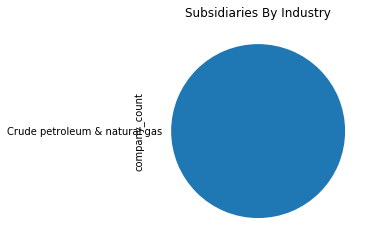

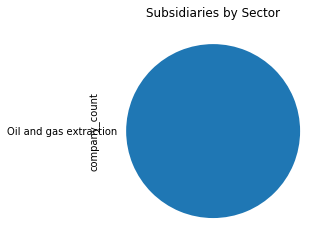

Rankings by number of subsidiaries for parent:
 * 152 largest of 227 in Mining group
 * 119 largest of 172 in Oil and gas extraction sector
 * 83 largest of 124 in Crude petroleum & natural gas industry
Subsidiaries locations: {'UNITED STATES'}
==================== SUBSIDIARIES BY INDUSTRY ============================= 
Crude petroleum & natural gas
	 	 	 Jones Energy Inc AUSTIN, TX 
Press Enter to return to the main menu


> 


Welcome to the Multinational Database

Instructions:
Using the database, you can either search for a specific company or for the largest companies in a sector
Which method would you like to choose?: 
A. Search by Company
B. Search by Sector


In [ ]:
def main():
    main_page()
    
main()